# Feature Detection in Images
The goal of this project is explore the VGG-16 model and the use of hypercolumns for feature extraction from images.

The model architecture and pretrained weights were obtained from https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

The model itself is described in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition", available here: https://arxiv.org/abs/1409.1556

The work closely follows the tutorial on hypercolumns here: http://blog.christianperone.com/tag/feature-extraction/

A dictionary for class names can be found here: http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
In this notebook, I just manually looked them up, but it could be done programatically without too much trouble.

For this hackathon, the main goals are to successfully extract hypercolumns from a new image (of my doggo Hiro!) and use them to identify where he is in an image.

#### Required Libraries
First I load required libraries and the model manipulation script.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2

# from sklearn.manifold import TSNE
# from sklearn import manifold
from sklearn import cluster
# from sklearn.preprocessing import StandardScaler

# Functions for loading and accessing the model.
import vgg16

# Load the pretrained VGG-16 model
model = vgg16.VGG_16('vgg16_weights.h5')


Using Theano backend.


#### Source Image
Here's where I upload the source image, and resize it to the expected 224x224 pixel size. 

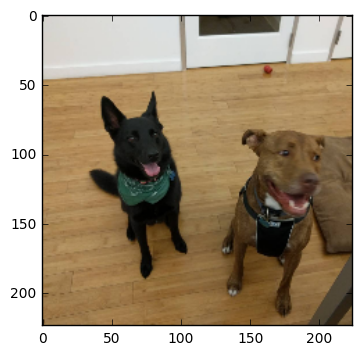

In [2]:
im_original = cv2.resize(cv2.imread('doggos.jpg'), (224, 224))
im = im_original.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
im_converted = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
plt.imshow(im_converted)

#### Classification
The model predicts that the most likely content of this image is class 227, which corresponds to a Kelpie.

227


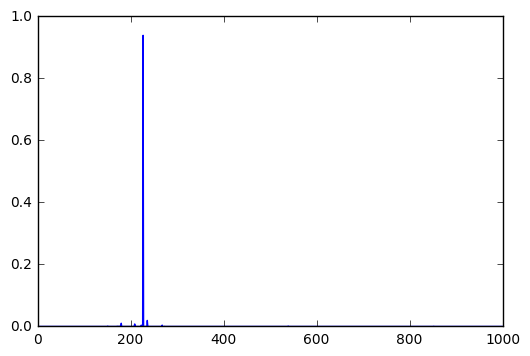

In [3]:
out = model.predict(im)
print np.argmax(out)
plt.plot(out.ravel())

 The Kelpie looks like a reasonable match for Hiro's friend Ginger.

![Image](kelpie.png)

## Hypercolumns
#### Analogy to RGB images
A typical image stored on a computer can be represented as an array of size [3, pixel width, pixel height]. Essentially, for every pixel, there are three values which specify the red, blue, and green content of that pixel. We could think of the mean of these three values as the 'intensity' of a pixel.

For a layer of a neural network, there can be many more than 3 channels. In this particular network, the first layer has 64, the second 128, the third 256, and the last two layers each have 512. Like RGB, for each layer we could take the average value across all channels and call this an intensity. This is what I've done for the next few images.


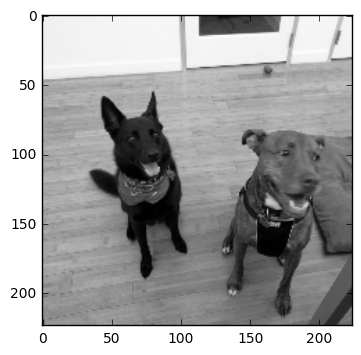

In [14]:
ave = np.average(im, axis = 1)
plt.imshow(ave[0], cmap = 'Greys_r')
plt.show()

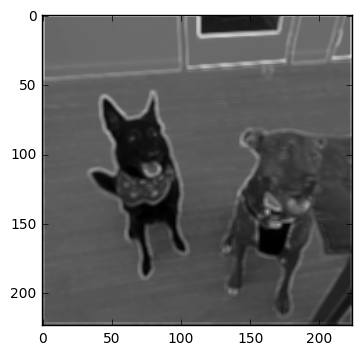

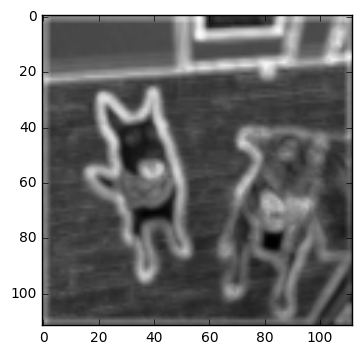

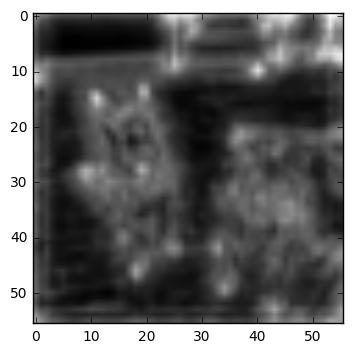

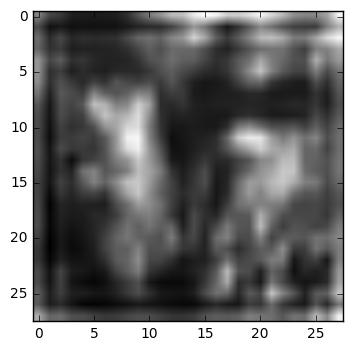

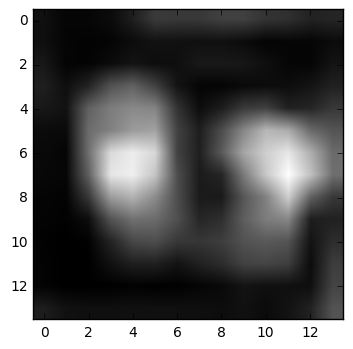

In [5]:
for layer in range(5):
    layer_intensity = vgg16.layer_intensity(model, layer, im)
    plt.imshow(layer_intensity, cmap = 'Greys_r')
    plt.show()

It looks like the intensity of the first layer corresponds roughly to edge detection, and the later ones are more to informational content. 

#### Hypercolumns as Feature Sets
Instead of aggregating the whole layer to a single value, we can keep individual actiavation for each pixel, and just stack all of them on top of one another. For this model, we'd then have 64 + 128 + 256 + 512 + 512 = 1472 values associated with each pixel. 

My code for generating this data is currently a bit messy and redundant (sorry!)


In [15]:
hypercolumn = np.ndarray(shape=[1472, 224, 224])
layer = vgg16.get_activations(model, 0, im)[0]
for i in range(layer.shape[1]):
    hypercolumn[i] = sp.misc.imresize(layer[0,i,:,:], size=(224, 224), mode="F", interp='bilinear')
    
layer = vgg16.get_activations(model, 1, im)[0]
for i in range(layer.shape[1]):
    hypercolumn[i+64] = sp.misc.imresize(layer[0,i,:,:], size=(224, 224), mode="F", interp='bilinear')

layer = vgg16.get_activations(model, 2, im)[0]
for i in range(layer.shape[1]):
    hypercolumn[i+192] = sp.misc.imresize(layer[0,i,:,:], size=(224, 224), mode="F", interp='bilinear')

layer = vgg16.get_activations(model, 3, im)[0]
for i in range(layer.shape[1]):
    hypercolumn[i+448] = sp.misc.imresize(layer[0,i,:,:], size=(224, 224), mode="F", interp='bilinear')

layer = vgg16.get_activations(model, 4, im)[0]
for i in range(layer.shape[1]):
    hypercolumn[i+960] = sp.misc.imresize(layer[0,i,:,:], size=(224, 224), mode="F", interp='bilinear')

#### Clustering

Now that we have a set of features associated with each pixel, we could calculate a feature-distance and use a clustering method. Unfortunately, this takes a long time (~10 minutes locally). The results are not too bad at identifying image components! In this one, we have 'floor', 'wall', 'dogs' and 'image-border'

Notably, however, the image boundary appears as one cluster. This might be due to the zero-padding operations present in the model.

In [12]:
m = hypercolumn.transpose(1,2,0).reshape(50176, -1)
kmeans = cluster.KMeans(n_clusters=4, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)

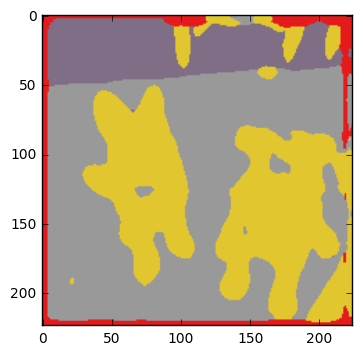

In [13]:
imcluster = np.zeros((224,224))
imcluster = imcluster.reshape((224*224,))
imcluster = cluster_labels
plt.imshow(imcluster.reshape(224, 224), cmap="Set1")

## Additional Work

Currently, the clustering treats all dimensions the same, but there's no reason that this should be the case. Perhaps the different layers carry more or less semantic information (probably later ones carry more). For that matter, k-means clustering is probably not even the best way to try and identify different features in the image. 

#### Bonus Image!

My wife took this beautiful picture of Hiro, and the VGG-16 model thinks he is a Coyote! After looking at some google image search results for coyote, it looks like maybe the straw background contributes some contextual information to the prediction!

272


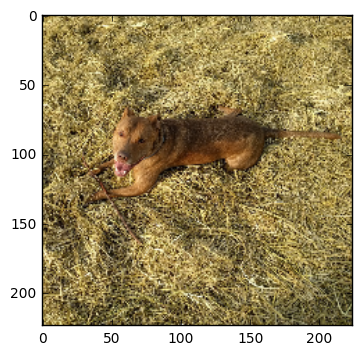

In [18]:
im_original2 = cv2.resize(cv2.imread('hiro2.jpg'), (224, 224))
im2 = im_original2.transpose((2,0,1))
im2 = np.expand_dims(im2, axis=0)
im_converted2 = cv2.cvtColor(im_original2, cv2.COLOR_BGR2RGB)
plt.imshow(im_converted2)
out = model.predict(im2)
print np.argmax(out)

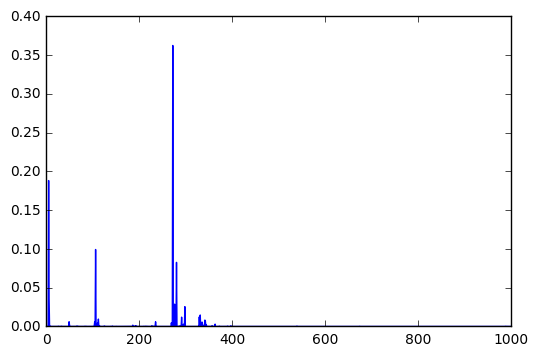

In [19]:
plt.plot(out.ravel())